## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
import scipy
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

## Loading the dataset

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Interpreting the content of the dataset

In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Feature Extraction

In [7]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

In [8]:
df['Invoice_Year'] = df.InvoiceDate.dt.year
df['Invoice_Month'] = df.InvoiceDate.dt.month
df['Invoice_Day'] = df.InvoiceDate.dt.day
df['Invoice_WeekDay'] = df.InvoiceDate.dt.weekday

In [9]:
df['Total Price'] = df.Quantity * df.UnitPrice

Customer ID is a unique identifier for each customer so it won't have any significance as far as clustering is concerned.


## Feature Preparation

In [10]:
df = df[(df.Quantity>0) & (df.UnitPrice>0)]
df.shape

(530104, 13)

In [11]:
X = df.drop(['InvoiceNo','StockCode','InvoiceDate','CustomerID'],axis=1)

## Categorical Encoding

In [12]:
encoder = LabelEncoder()
X.Description = encoder.fit_transform(X.Description.astype(str))
X.Description = X.Description.astype(np.int64)

## Outlier Treatment

In [13]:
for col in X.columns:
    if X[col].dtypes != object:
        lower_limit, upper_limit = X[col].quantile([0.25,0.75])
        IQR = upper_limit - lower_limit
        lower_whisker = lower_limit - 1.5 * IQR
        upper_whisker = upper_limit + 1.5 * IQR
        index = X[(X[col]<lower_whisker) & (X[col]>upper_whisker)].index
        X.drop(index,inplace=True)

## EDA

<AxesSubplot:>

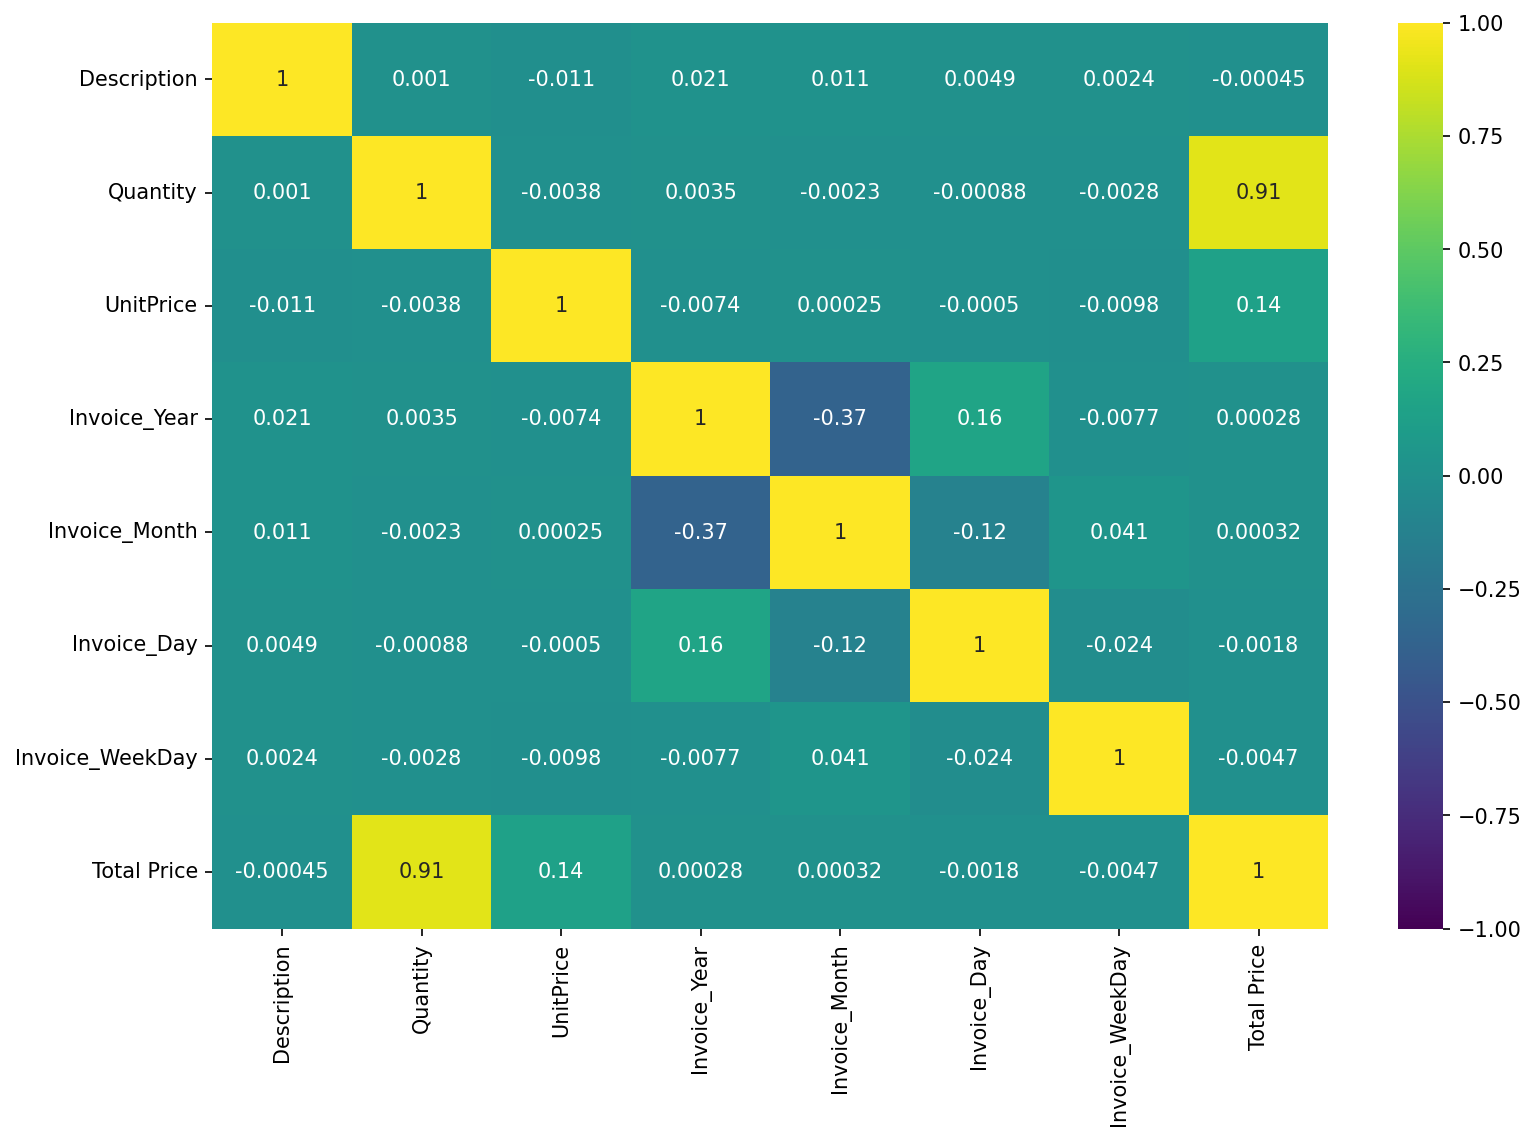

In [14]:
plt.figure(figsize=(12,8),dpi=150)
sns.heatmap(X.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

<AxesSubplot:xlabel='Quantity', ylabel='Total Price'>

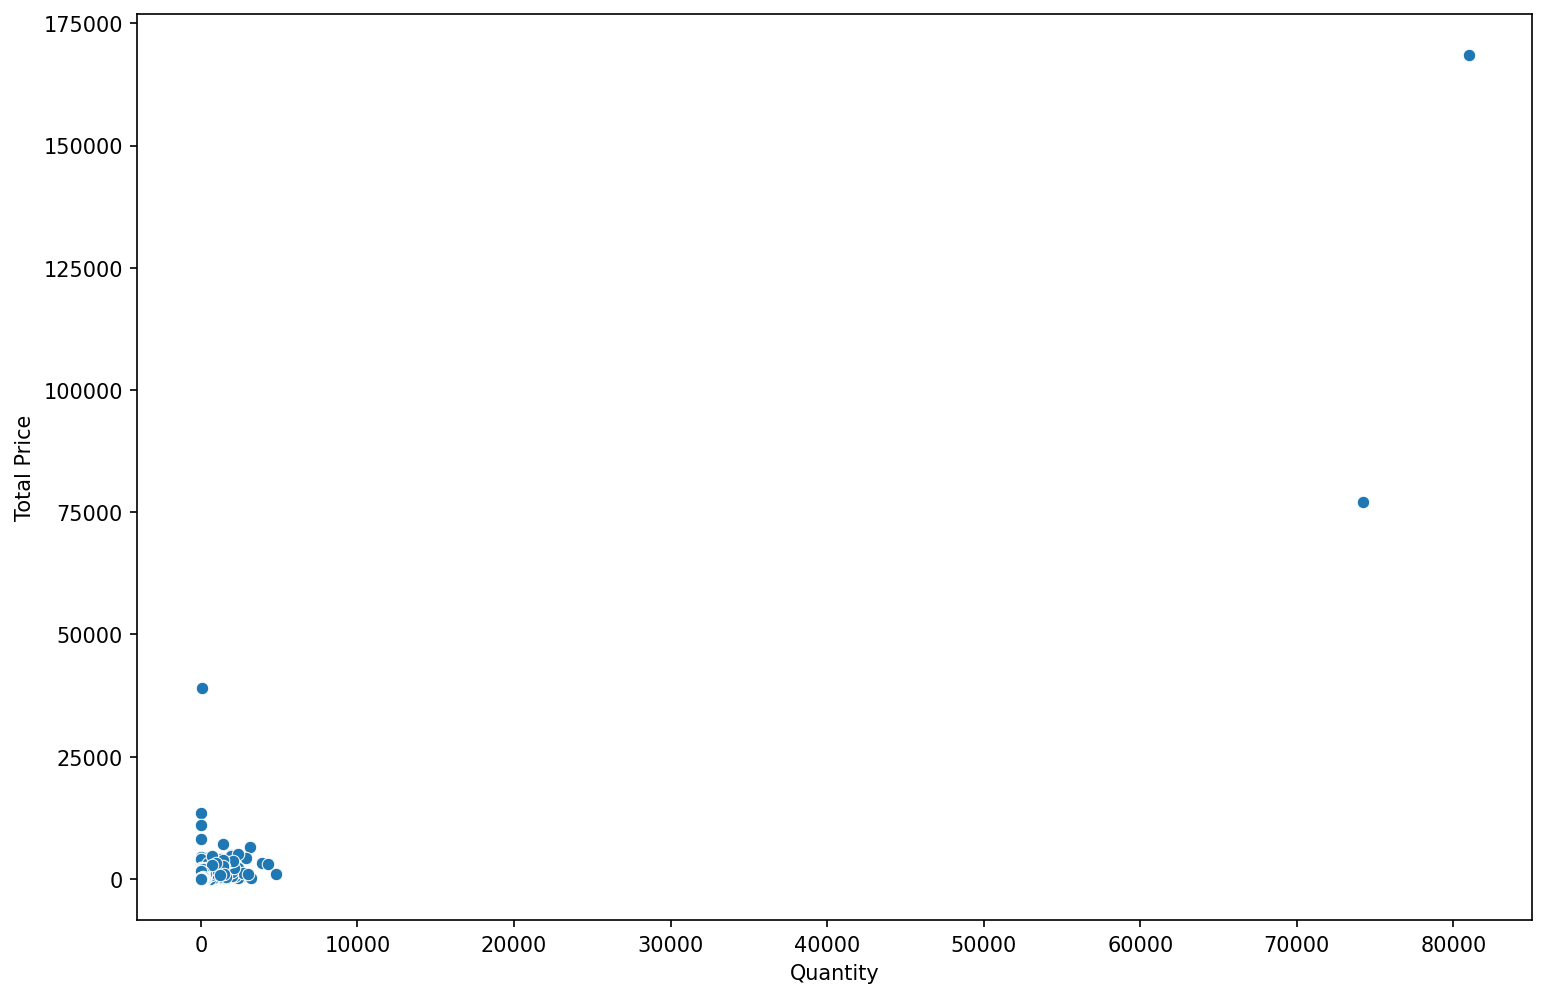

In [15]:
plt.figure(figsize=(12,8),dpi=150)
sns.scatterplot(data=X,x='Quantity',y='Total Price')

In [16]:
X.describe()

,Description,Quantity,UnitPrice,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_WeekDay,Total Price
count,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000
mean,2080.782282,10.542037,3.907625,2010.921751,7.560611,15.020922,2.436626,20.121871
std,1127.280809,155.524124,35.915681,0.268563,3.508496,8.661560,1.850651,270.356743
min,0.000000,1.000000,0.001000,2010.000000,1.000000,1.000000,0.000000,0.001000
25%,1166.000000,1.000000,1.250000,2011.000000,5.000000,7.000000,1.000000,3.750000
50%,2038.000000,3.000000,2.080000,2011.000000,8.000000,15.000000,2.000000,9.900000
75%,3062.000000,10.000000,4.130000,2011.000000,11.000000,22.000000,4.000000,17.700000
max,4025.000000,80995.000000,13541.330000,2011.000000,12.000000,31.000000,6.000000,168469.600000


<AxesSubplot:xlabel='Invoice_Year'>

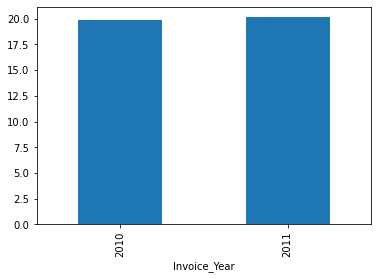

In [17]:
X.groupby('Invoice_Year')['Total Price'].mean().plot(kind='bar')

<AxesSubplot:xlabel='Invoice_Year', ylabel='count'>

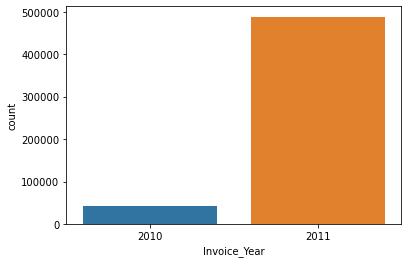

In [18]:
sns.countplot(X.Invoice_Year)

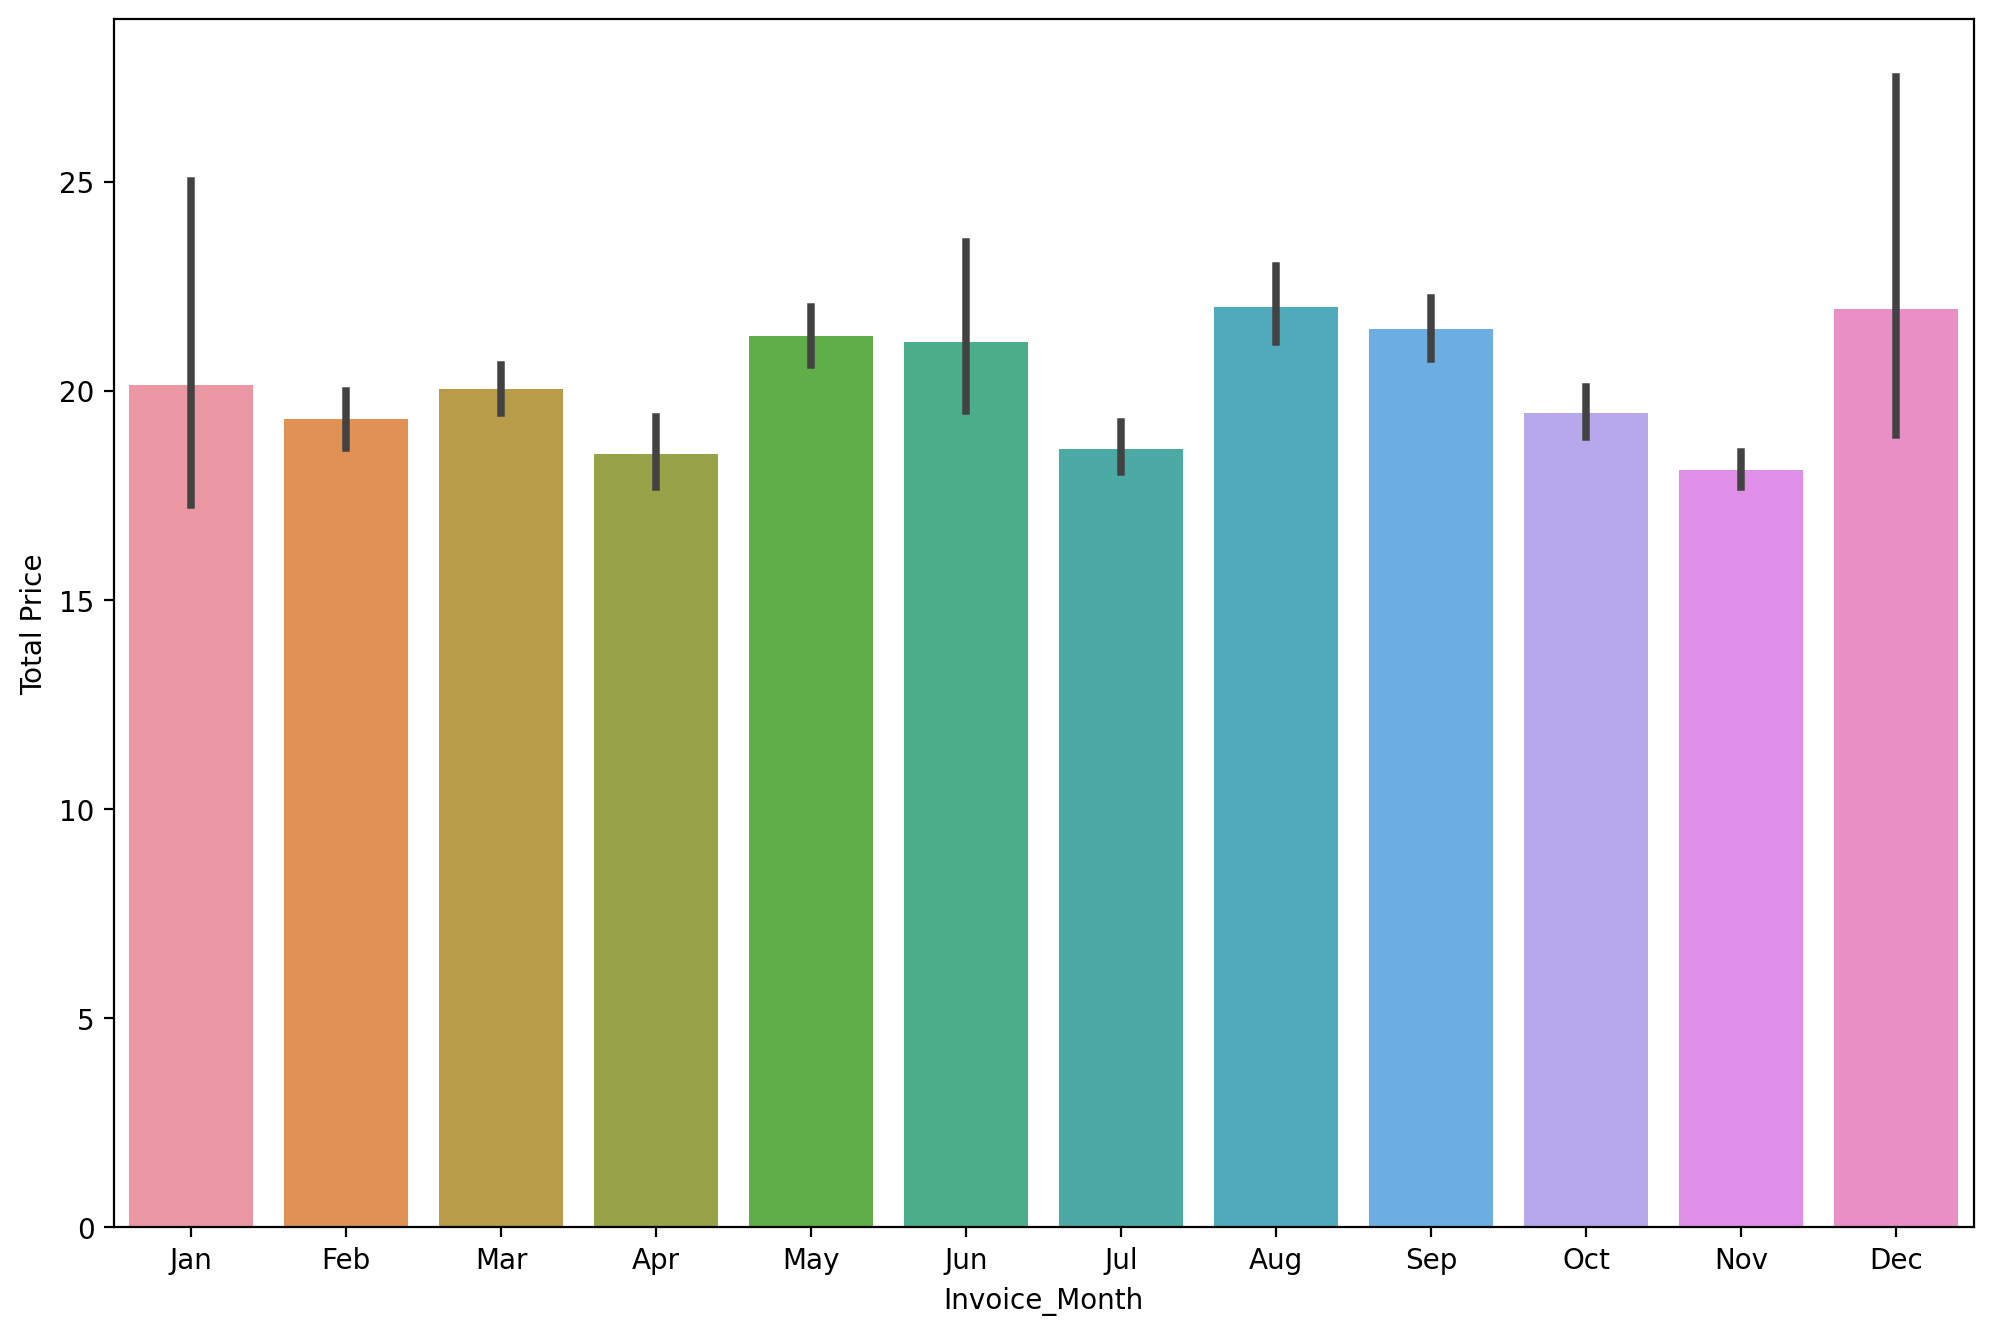

In [19]:
plt.figure(figsize=(12,8),dpi=200)
ax = sns.barplot(data=X,x='Invoice_Month',y='Total Price')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

<AxesSubplot:xlabel='Invoice_Day', ylabel='Total Price'>

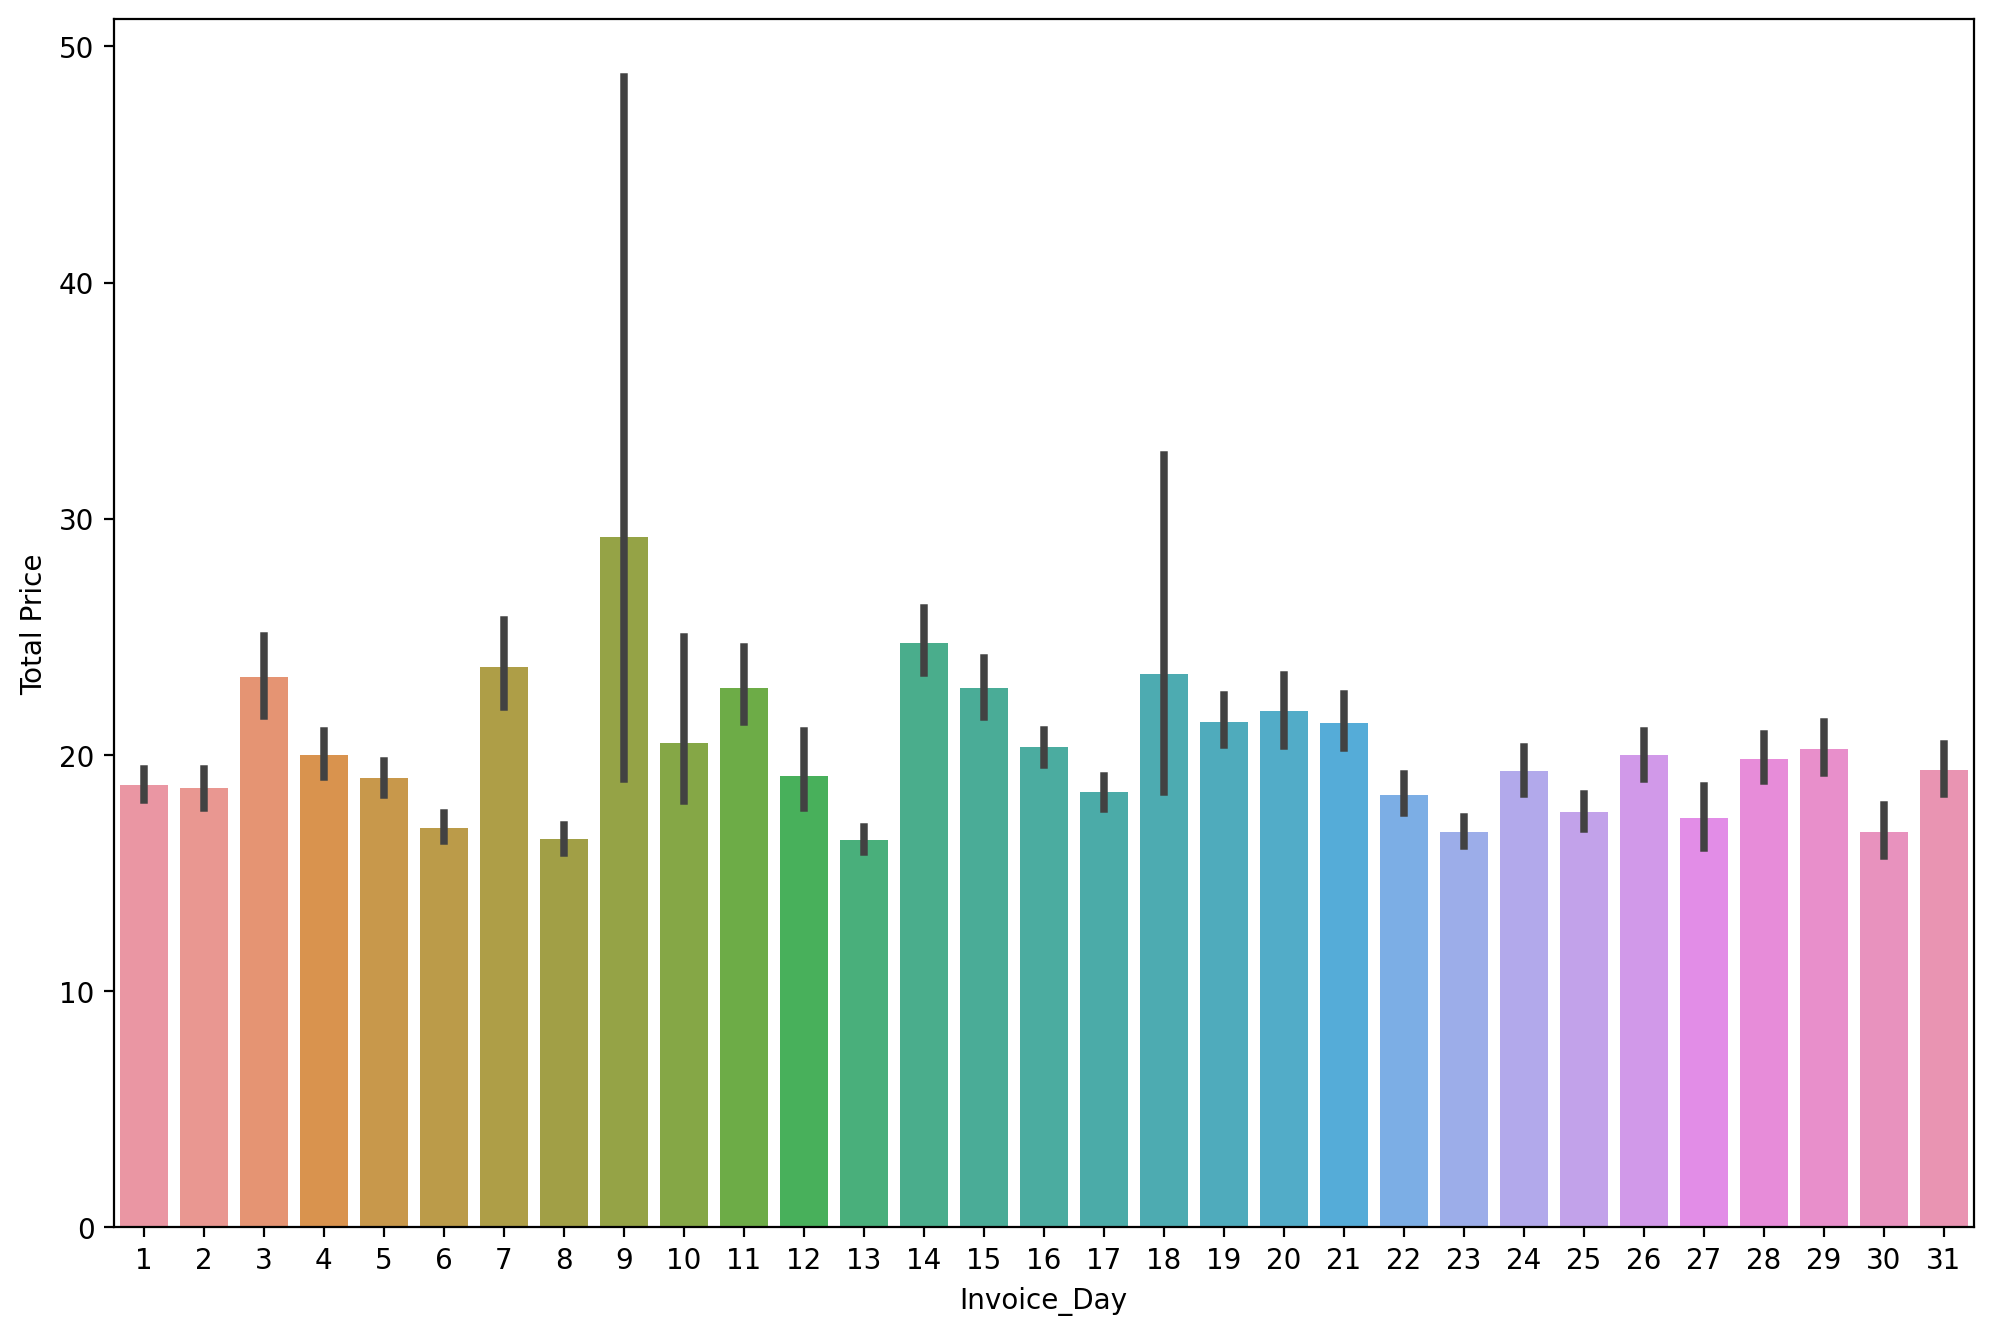

In [20]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(data=X,x='Invoice_Day',y='Total Price')

## Univariate Analysis

Skewness of Quantity: 471.7277163313442
Kurtosis of Quantity: 236462.34282634672


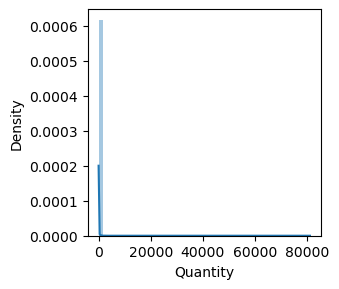

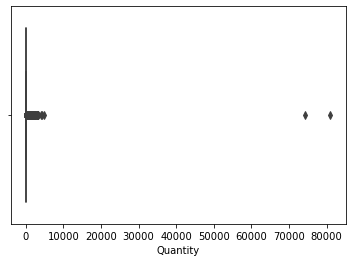

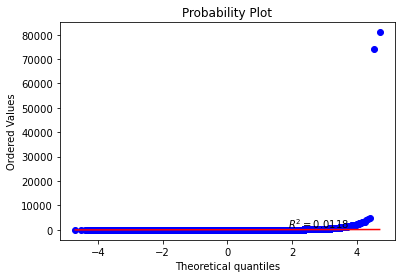

Skewness of UnitPrice: 206.08755495006463
Kurtosis of UnitPrice: 62483.14271510476


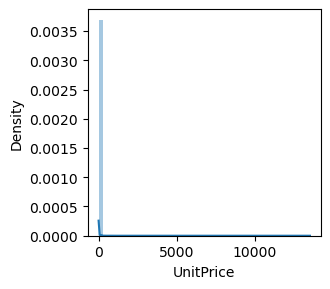

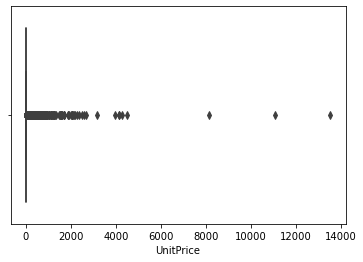

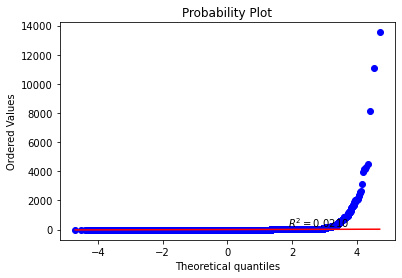

Skewness of Invoice_Year: -3.140811448329451
Kurtosis of Invoice_Year: 7.8647262263308715


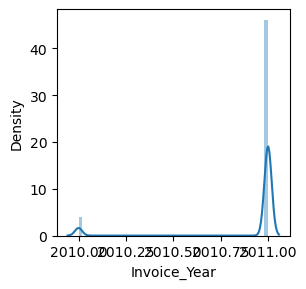

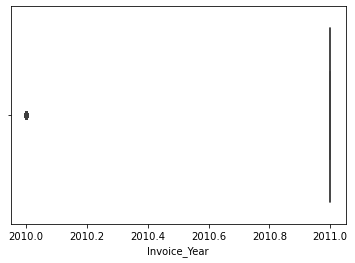

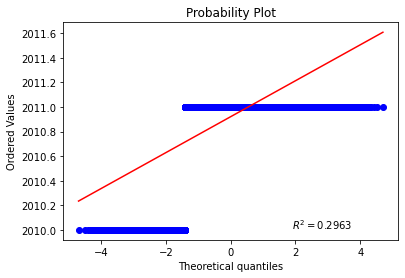

Skewness of Invoice_Month: -0.41841228696053556
Kurtosis of Invoice_Month: -1.1169946588288


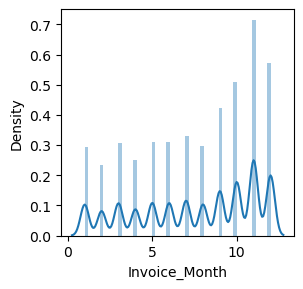

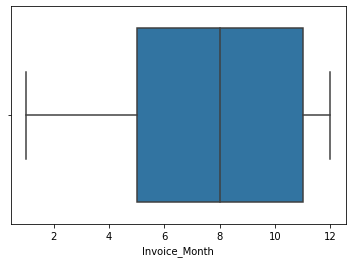

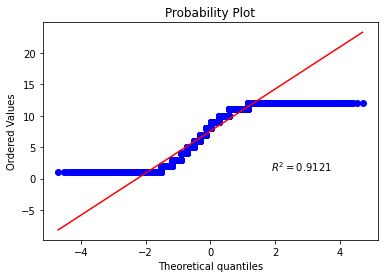

Skewness of Invoice_Day: 0.14208619030549433
Kurtosis of Invoice_Day: -1.1574107092128816


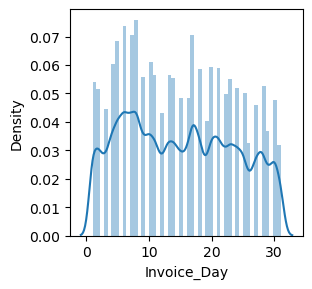

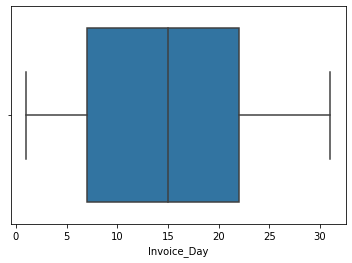

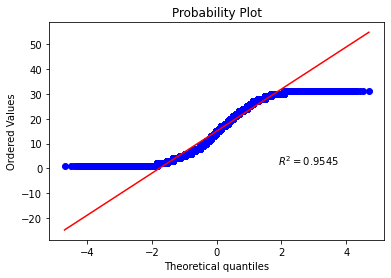

Skewness of Invoice_WeekDay: 0.4661824816962572
Kurtosis of Invoice_WeekDay: -0.6675789760994388


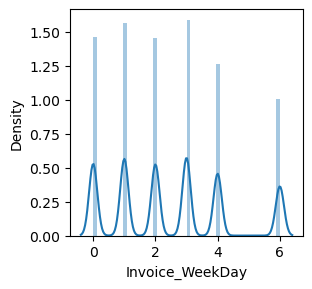

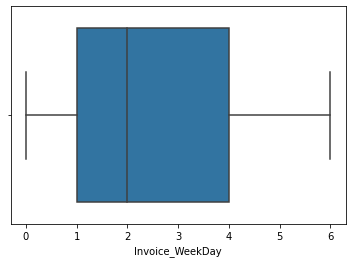

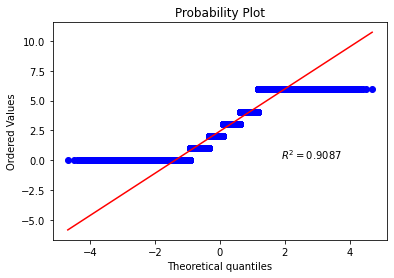

Skewness of Total Price: 506.7060119422723
Kurtosis of Total Price: 297651.6610458157


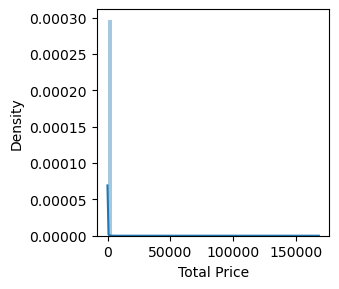

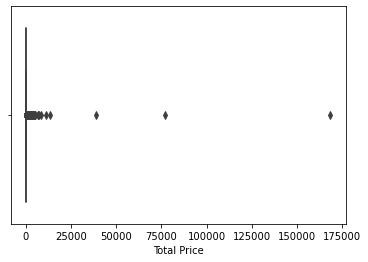

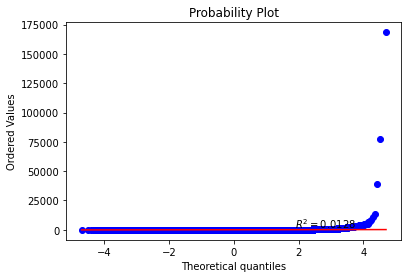

In [21]:
for col in X.columns:
    if col not in ['Description','InvoiceYear']:
        if X[col].dtypes != object:
            print("Skewness of {}:".format(col),X[col].skew())
            print("Kurtosis of {}:".format(col),X[col].kurt())
            plt.figure(figsize=(3,3),dpi=100)
            sns.distplot(X[col])
            plt.show()
            sns.boxplot(data=X,x=col)
            plt.show()
            scipy.stats.probplot(X[col],plot=plt,rvalue=True)
            plt.show()

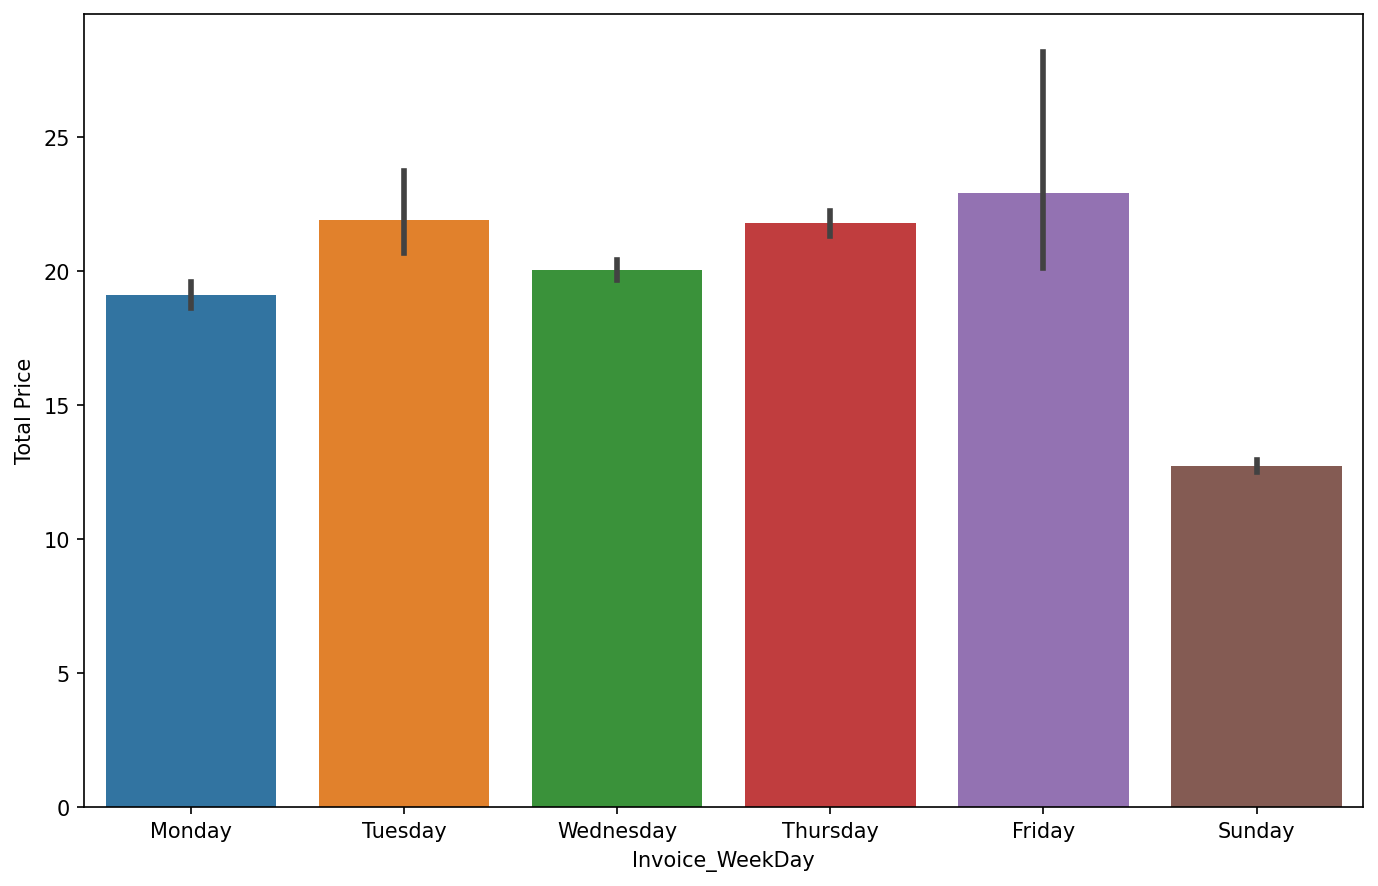

In [22]:
plt.figure(figsize=(11,7),dpi=150)
ax = sns.barplot(data=X,x='Invoice_WeekDay',y='Total Price')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']);

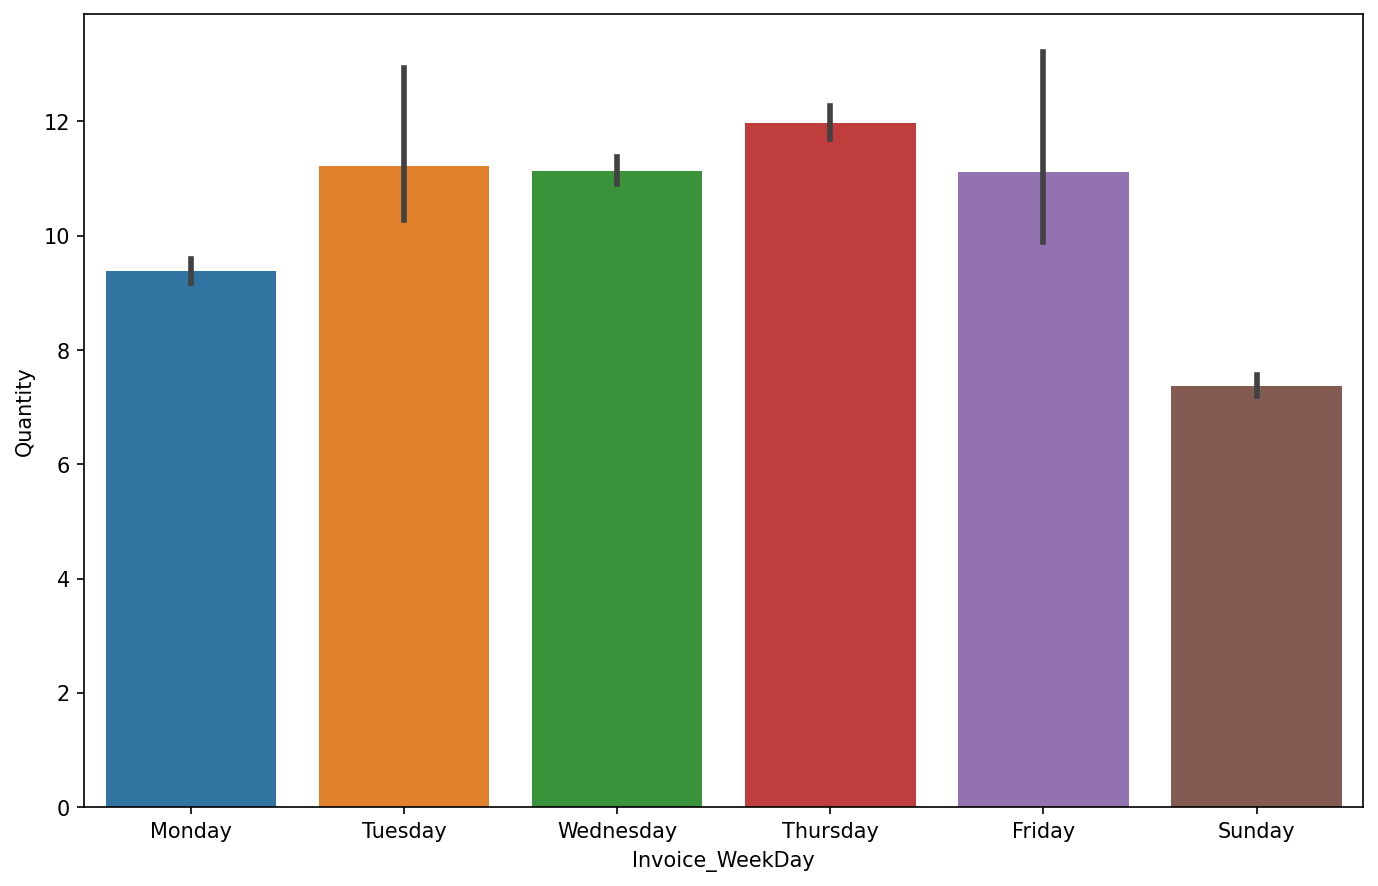

In [23]:
plt.figure(figsize=(11,7),dpi=150)
ax = sns.barplot(data=X,x='Invoice_WeekDay',y='Quantity')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']);

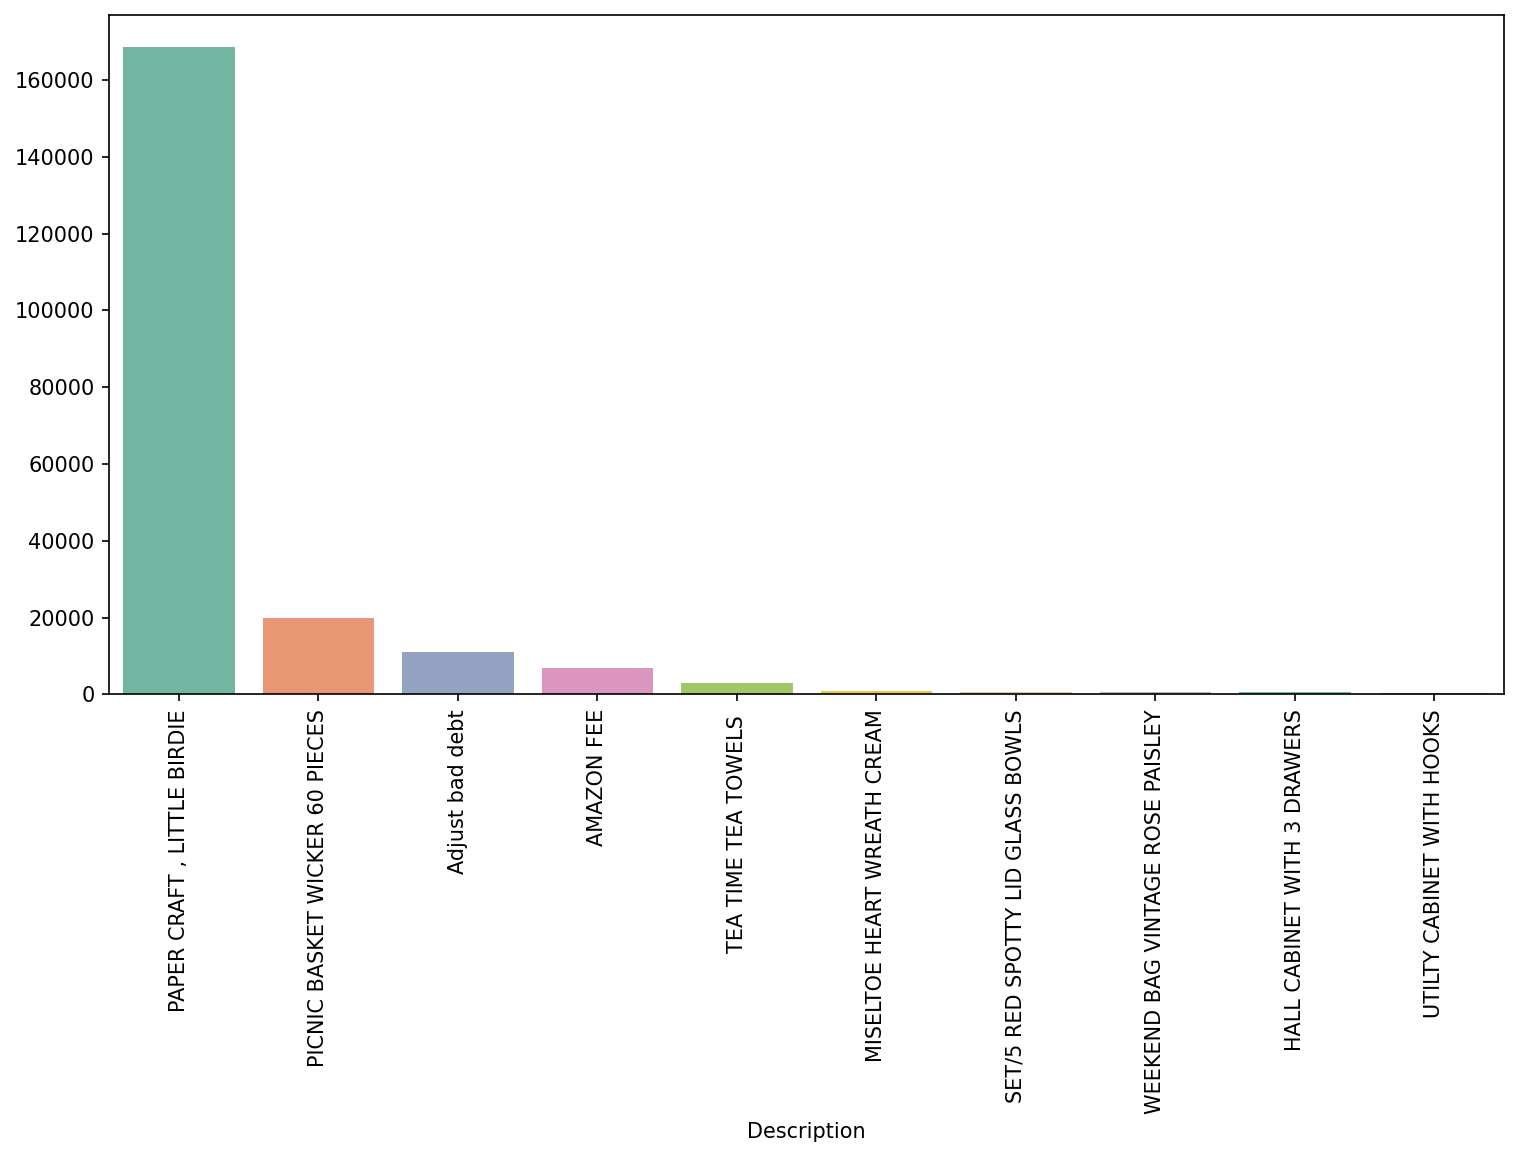

In [24]:
plt.figure(figsize=(12,6),dpi=150)
sns.barplot(df.groupby('Description')['Total Price'].mean().sort_values(ascending=False)[:10].index,df.groupby('Description')['Total Price'].mean().sort_values(ascending=False)[:10].values,palette='Set2')
plt.xticks(rotation=90);

## Feature Engineering Continued

In [25]:
X = pd.get_dummies(X)
X.head()

,Description,Quantity,UnitPrice,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_WeekDay,Total Price,Country_Australia,Country_Austria,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,3844,6,2.55,2010,12,1,2,15.30,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3852,6,3.39,2010,12,1,2,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0
2,888,8,2.75,2010,12,1,2,22.00,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1859,6,3.39,2010,12,1,2,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2849,6,3.39,2010,12,1,2,20.34,0,0,...,0,0,0,0,0,0,0,0,1,0


## Feature Scaling

In [26]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X,columns=X.columns)
scaled_X.head()

,Description,Quantity,UnitPrice,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_WeekDay,Total Price,Country_Australia,Country_Austria,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,1.564135,-0.029205,-0.037800,-3.432164,1.265327,-1.618754,-0.235931,-0.017835,-0.047273,-0.027411,...,-0.01037,-0.00412,-0.020469,-0.068614,-0.02918,-0.061012,-0.018379,-0.011327,0.304501,-0.029018
1,1.571232,-0.029205,-0.014412,-3.432164,1.265327,-1.618754,-0.235931,0.000807,-0.047273,-0.027411,...,-0.01037,-0.00412,-0.020469,-0.068614,-0.02918,-0.061012,-0.018379,-0.011327,0.304501,-0.029018
2,-1.058107,-0.016345,-0.032232,-3.432164,1.265327,-1.618754,-0.235931,0.006947,-0.047273,-0.027411,...,-0.01037,-0.00412,-0.020469,-0.068614,-0.02918,-0.061012,-0.018379,-0.011327,0.304501,-0.029018
3,-0.196741,-0.029205,-0.014412,-3.432164,1.265327,-1.618754,-0.235931,0.000807,-0.047273,-0.027411,...,-0.01037,-0.00412,-0.020469,-0.068614,-0.02918,-0.061012,-0.018379,-0.011327,0.304501,-0.029018
4,0.681479,-0.029205,-0.014412,-3.432164,1.265327,-1.618754,-0.235931,0.000807,-0.047273,-0.027411,...,-0.01037,-0.00412,-0.020469,-0.068614,-0.02918,-0.061012,-0.018379,-0.011327,0.304501,-0.029018


In [27]:
scaled_X.drop('Invoice_Year',axis=1,inplace=True)
X.drop('Invoice_Year',axis=1,inplace=True)

## Model Training & Assessment

In [28]:
kmeans_model = KMeans()
cluster_labels = kmeans_model.fit_predict(scaled_X)
cluster_labels

array([1, 1, 1, ..., 0, 0, 0])

In [29]:
ssd = []

for i in range(2,13):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_X)
    ssd.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Method')

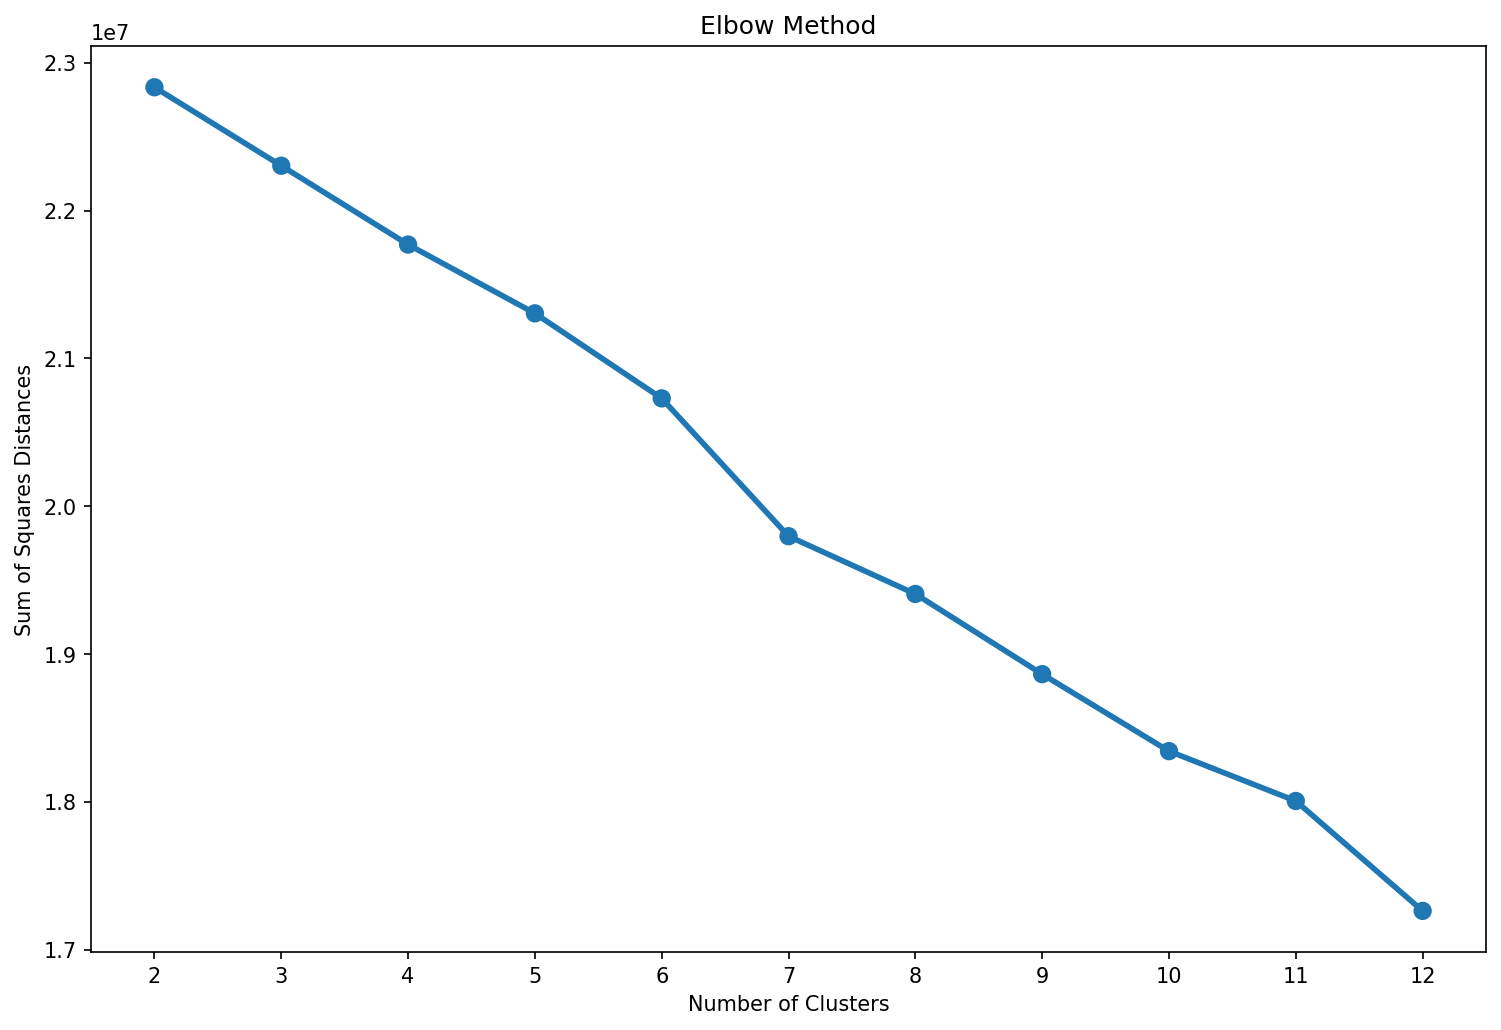

In [30]:
plt.figure(figsize=(12,8),dpi=150)
sns.pointplot(np.arange(2,13),ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Distances')
plt.title('Elbow Method')

In [31]:
model = KMeans(n_clusters=12,random_state=101)
model.fit(scaled_X)

KMeans(n_clusters=12, random_state=101)

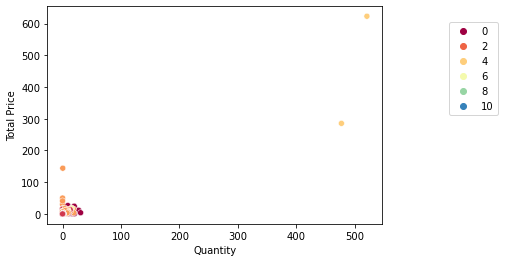

In [32]:
sns.scatterplot(data=scaled_X,x='Quantity',y='Total Price',hue=model.labels_,palette='Spectral')
plt.legend(loc=(1.2,0.5))

In [33]:
scaled_X['Segment'] = model.labels_
X['Segment'] = model.labels_

<AxesSubplot:xlabel='Segment'>

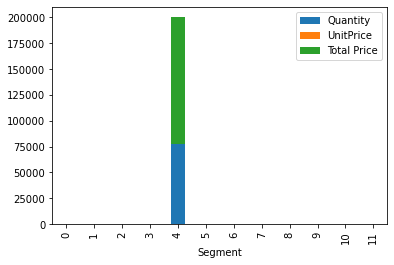

In [34]:
X.groupby('Segment')[['Quantity','UnitPrice','Total Price']].mean().plot(kind='bar',stacked=True)

In [35]:
temp = scaled_X.sample(n=15000)
silhouette_score(temp,temp.Segment)

0.41843583215704633

## Density-based Spatial Clustering of Applications with Noise(DBSCAN)

In [36]:
temp = scaled_X.sample(n=10000)

In [37]:
dbscan = DBSCAN()
dbscan.fit(temp)

DBSCAN()

In [38]:
percent_outliers = []
min_samples = 2 * temp.shape[1]

for eps in np.linspace(0.001,5,50):
    dbscan = DBSCAN(eps=eps,min_samples=min_samples)
    dbscan.fit(temp)
    percent_outliers.append(np.sum(dbscan.labels_==-1)/len(dbscan.labels_))

Text(0, 0.5, 'Percentage of Outliers')

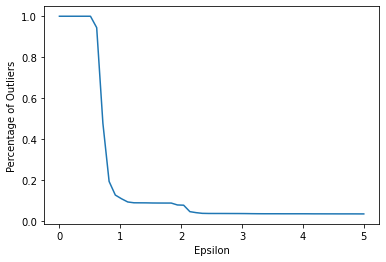

In [39]:
sns.lineplot(np.linspace(0.001,5,50),percent_outliers)
plt.xlabel('Epsilon')
plt.ylabel('Percentage of Outliers')

## Optimized DBSCAN Model

In [40]:
silhouette_scores = []

for i in np.linspace(1.5,5,50):
    dbscan = DBSCAN(eps=i)
    dbscan.fit(temp)
    temp['Segment'] = dbscan.labels_
    silhouette_scores.append(silhouette_score(temp,temp.Segment))

Text(0, 0.5, 'Silhouette Score')

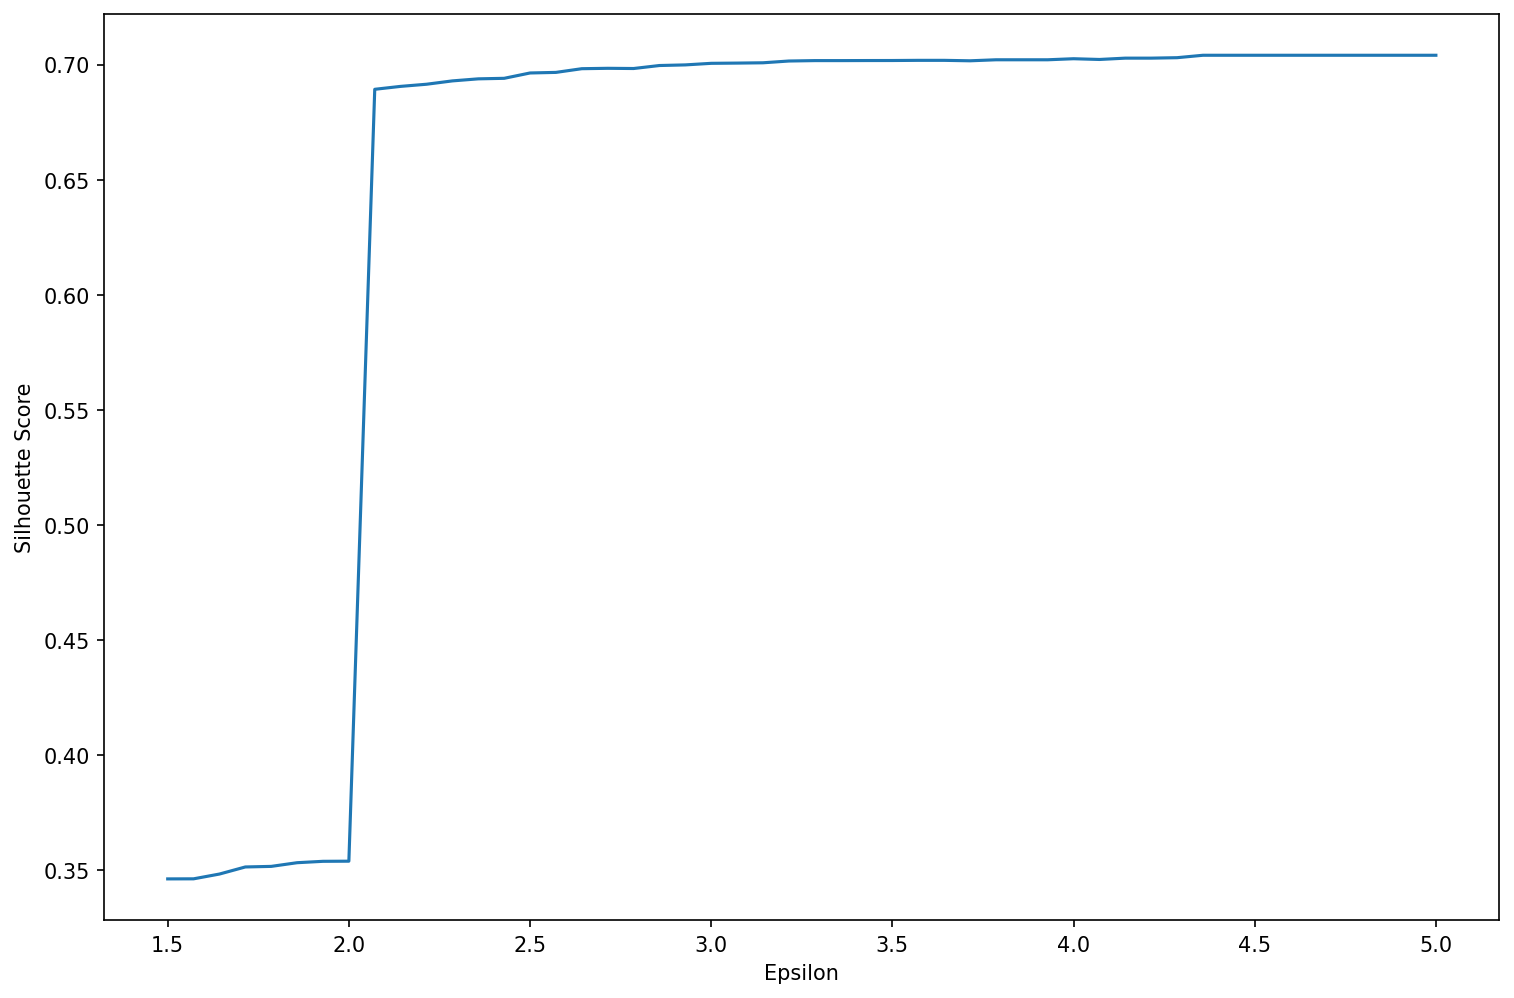

In [41]:
plt.figure(figsize=(12,8),dpi=150)
sns.lineplot(np.linspace(1.5,5,50),silhouette_scores)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')

In [42]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X)                          
    distances = np.sort(distances[:,k-1], axis=0)
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    return distances[knee.knee]

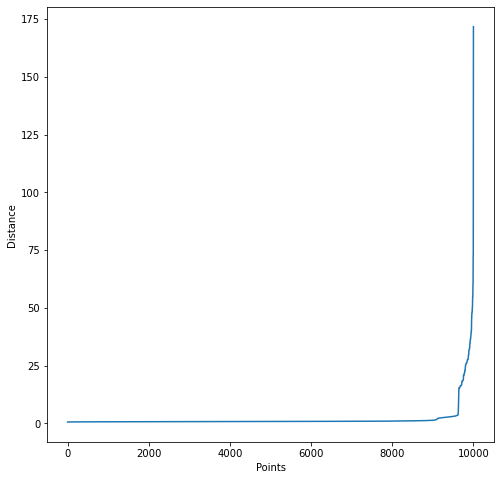

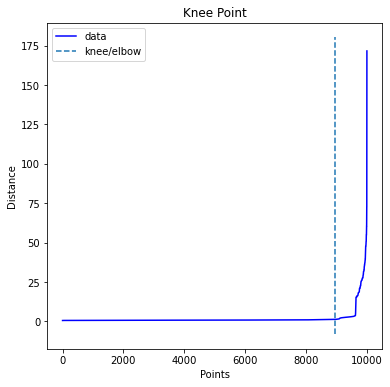

Knee Point: 1.2673709831538964


In [43]:
k = 2 * temp.shape[-1] 
x = get_kdist_plot(temp,k)
print("Knee Point:",x)

### Now, let's try to find out the optimum value of min_samples hyperparameter as we have already found the best possible eps value..

In [44]:
ms = np.linspace(3,min_samples,50)
silhouette_scores = []

for i in ms:
    dbscan = DBSCAN(eps=x,min_samples=i)
    dbscan.fit(temp)
    temp['Segment'] = dbscan.labels_
    silhouette_scores.append(silhouette_score(temp,temp.Segment))

Text(0, 0.5, 'Silhouette Score')

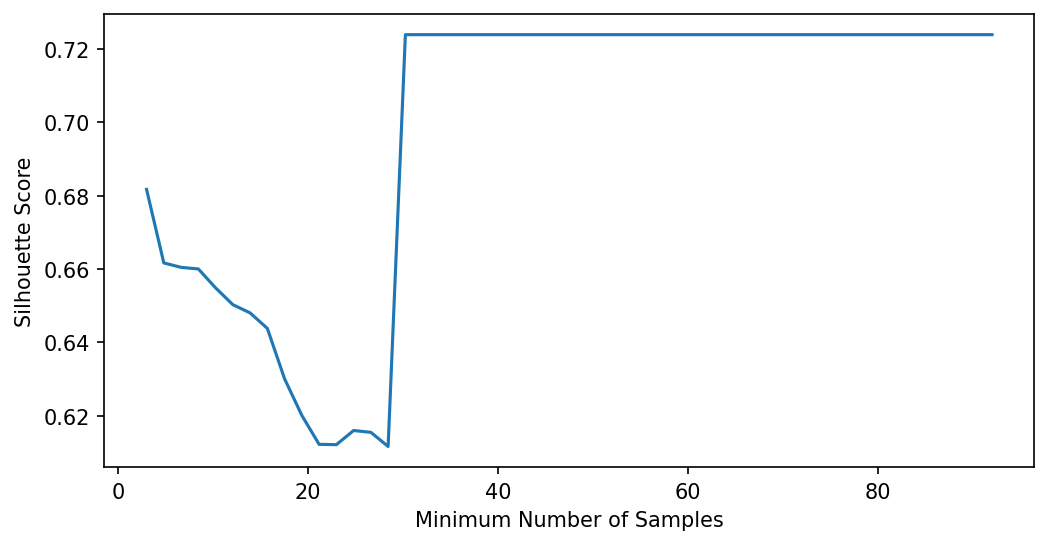

In [45]:
plt.figure(figsize=(8,4),dpi=150)
sns.lineplot(ms,silhouette_scores)
plt.xlabel('Minimum Number of Samples')
plt.ylabel('Silhouette Score')

47


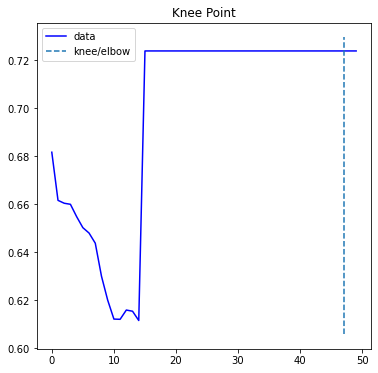

In [46]:
knee = KneeLocator(np.arange(len(silhouette_scores)), silhouette_scores, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
print(np.arange(len(silhouette_scores))[knee.knee])

In [47]:
dbscan_model = DBSCAN(eps=x,min_samples=2*min_samples)
dbscan_model.fit(temp)

DBSCAN(eps=1.2673709831538964, min_samples=184)

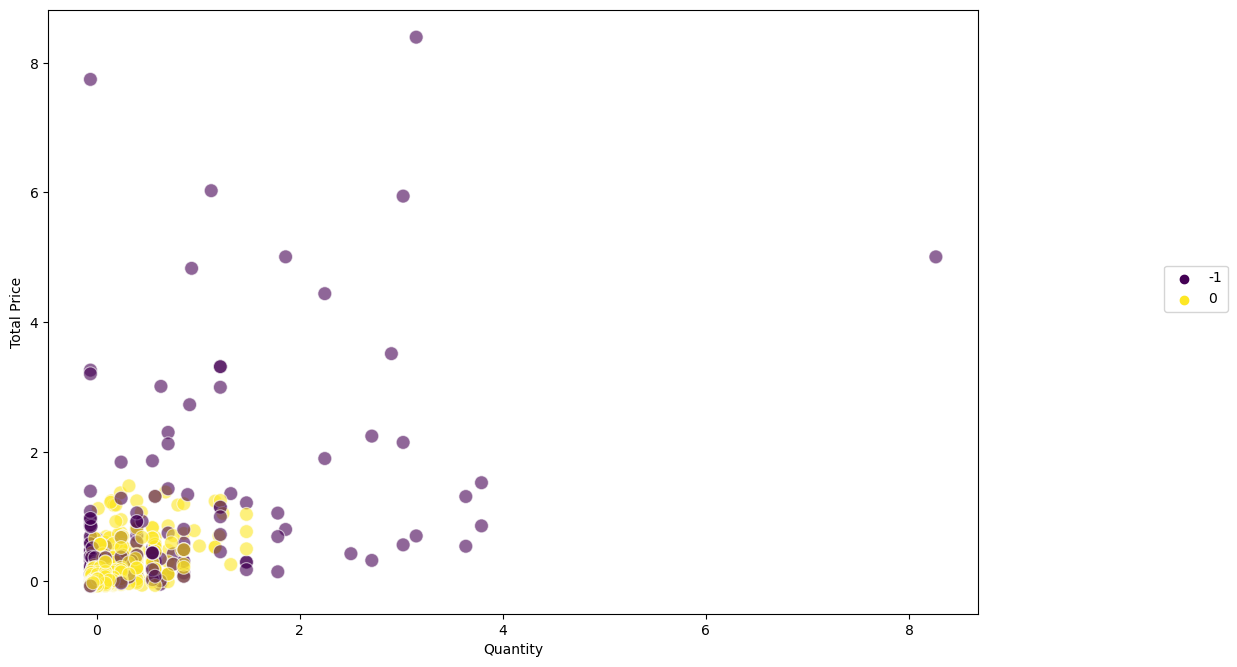

In [48]:
plt.figure(figsize=(12,8),dpi=100)
sns.scatterplot(temp.Quantity,temp['Total Price'],hue=dbscan_model.labels_,palette='viridis',s=100,alpha=0.6)
plt.legend(loc=(1.2,0.5))

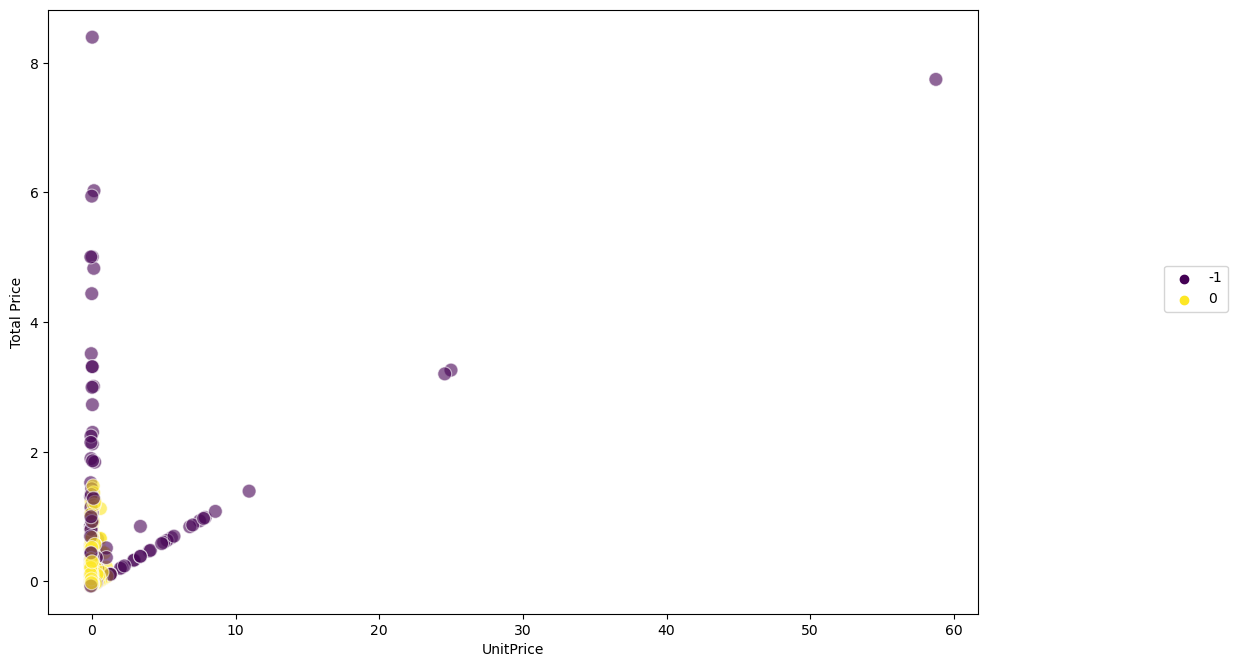

In [49]:
plt.figure(figsize=(12,8),dpi=100)
sns.scatterplot(temp.UnitPrice,temp['Total Price'],hue=dbscan_model.labels_,palette='viridis',s=100,alpha=0.6)
plt.legend(loc=(1.2,0.5))

In [50]:
labels = dbscan_model.labels_
print("Estimated number of cluster labels:",len(np.unique(labels)-[-1]))

Estimated number of cluster labels: 2


In [51]:
#Identify Noise
print("Percentage of noise points:",str(round(list(labels).count(-1) / len(labels) * 100,2)) + '%')

Percentage of noise points: 9.02%


In [52]:
temp['Segment'] = dbscan_model.labels_
print("Silhouette Score:",str(round(silhouette_score(temp,temp.Segment)*100,2)) + '%')

Silhouette Score: 72.23%


In [53]:
original_temp = scaler.inverse_transform(temp)
original_temp = pd.DataFrame(original_temp,columns=temp.columns)
original_temp.head()

,Description,Quantity,UnitPrice,Invoice_Month,Invoice_Day,Invoice_WeekDay,Total Price,Country_Australia,Country_Austria,Country_Bahrain,...,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Segment
0,1604.0,12.0,2.10,2011.108478,11.197722,3.616839,2.471387,7.341316,0.000937,0.000591,...,0.000065,-0.000067,-0.000985,0.002693,-0.000928,0.002592,0.00013,0.003577,0.907061,0.000841
1,2534.0,3.0,4.13,2010.419560,8.362266,3.616839,2.383699,7.341316,0.000937,0.000591,...,0.000065,-0.000067,-0.000985,0.002693,-0.000928,0.002592,0.00013,0.003577,0.907061,0.000841
2,3128.0,1.0,1.63,2010.496106,10.387591,8.297116,2.310045,7.341316,0.000937,0.000591,...,0.000065,-0.000067,-0.000985,0.002693,-0.000928,0.002592,0.00013,0.003577,0.907061,0.000841
3,513.0,12.0,1.45,2011.031931,4.311615,12.977393,2.417994,7.341316,0.000937,0.000591,...,0.000065,-0.000067,-0.000985,0.002693,-0.000928,0.002592,0.00013,-0.037064,0.907061,-0.028152
4,2667.0,48.0,0.79,2010.649199,1.881225,22.337947,2.558458,7.341316,0.000937,0.000591,...,0.000065,-0.000067,-0.000985,0.002693,-0.000928,0.002592,0.00013,0.003577,0.907061,0.000841


In [54]:
original_temp['Segment'] = dbscan_model.labels_

<AxesSubplot:xlabel='Segment'>

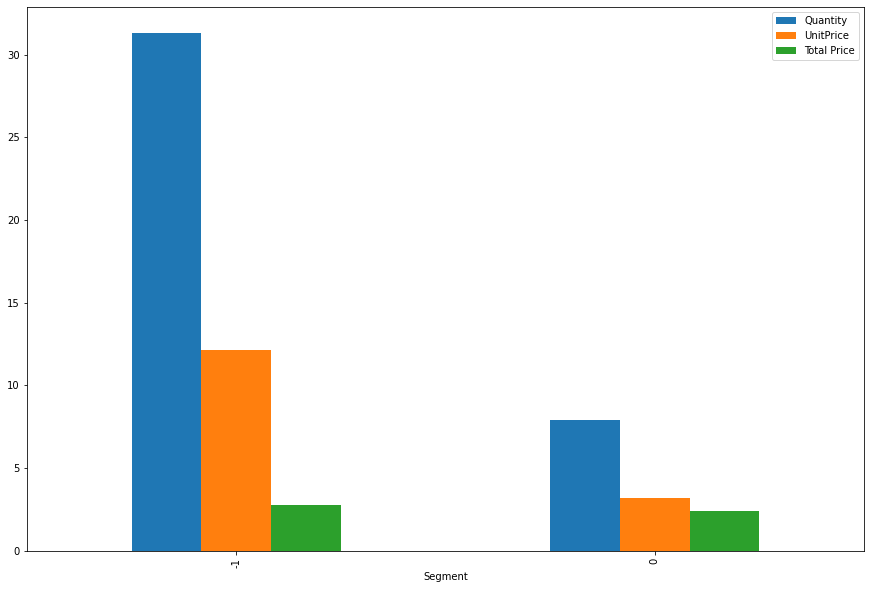

In [55]:
# plt.figure(figsize=(12,8),dpi=150)
original_temp.groupby('Segment')[['Quantity','UnitPrice','Total Price']].mean().plot(kind='bar',figsize=(15,10))

<AxesSubplot:xlabel='Segment', ylabel='count'>

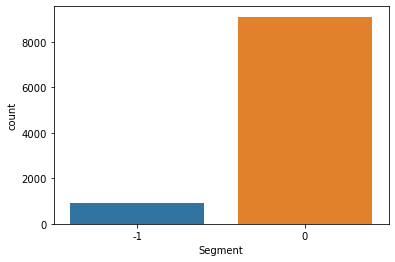

In [56]:
sns.countplot(original_temp.Segment)

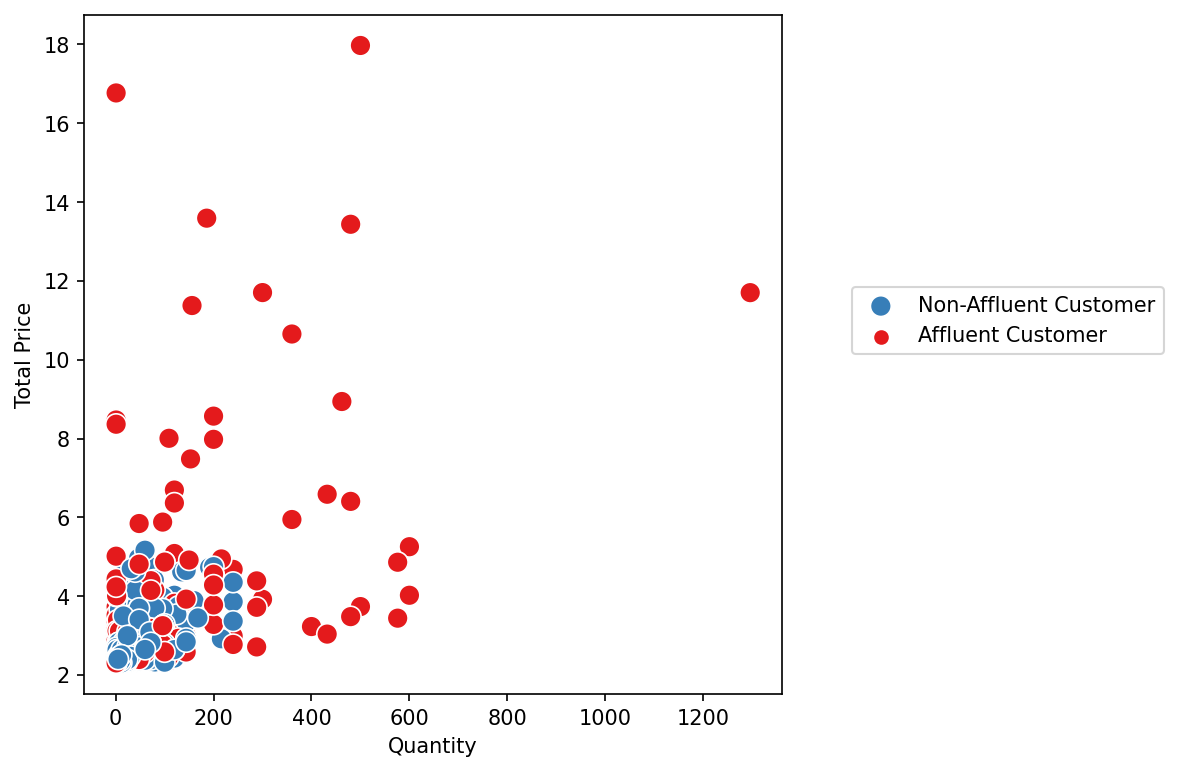

In [57]:
plt.figure(figsize=(6,6),dpi=150)
labels = ['Non-Affluent Customer','Affluent Customer']
sns.scatterplot(data=original_temp,x='Quantity',y='Total Price',hue='Segment',palette='Set1',s=100,x_jitter=0.4,y_jitter=0.5)
plt.legend(loc=(1.1,0.5),labels=labels)

The DBSCAN model has classified the customers mainly into 2 segments, first group includes the affluent and wealthy customers who spend extortionate amounts on exorbitant products whereas the second group includes substandard and penurious customers who don't have adequate financial income to afford high-quality expensive products. The first group has primarily been referred to as an outlier by the DBSCAN model considering its massive range of expenditure values with regard to quantities ordered and total price expended.